In [ ]:
from google.colab import files
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

uploaded = files.upload()



Saving isolated_words_per_user.zip to isolated_words_per_user.zip


In [ ]:
# unzip file
print("Uploaded files:")
print(os.listdir('/content'))
!unzip isolated_words_per_user.zip -d /content/extracted_files

Streaming output truncated to the last 5000 lines.
  inflating: /content/extracted_files/isolated_words_per_user/user032/user032_shateerah_035.png  
  inflating: /content/extracted_files/isolated_words_per_user/user032/user032_shateerah_036.png  
  inflating: /content/extracted_files/isolated_words_per_user/user032/user032_shateerah_037.png  
  inflating: /content/extracted_files/isolated_words_per_user/user032/user032_shateerah_038.png  
  inflating: /content/extracted_files/isolated_words_per_user/user032/user032_shateerah_039.png  
  inflating: /content/extracted_files/isolated_words_per_user/user032/user032_shateerah_040.png  
   creating: /content/extracted_files/isolated_words_per_user/user033/
  inflating: /content/extracted_files/isolated_words_per_user/user033/user033_abjadiyah_031.png  
  inflating: /content/extracted_files/isolated_words_per_user/user033/user033_abjadiyah_032.png  
  inflating: /content/extracted_files/isolated_words_per_user/user033/user033_abjadiyah_033.pn

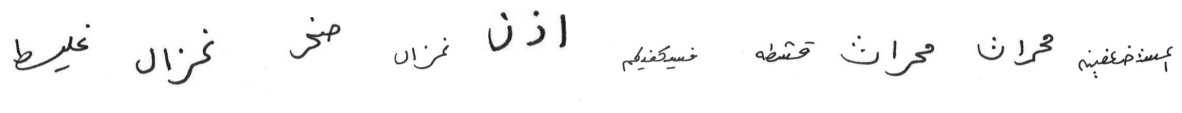

In [ ]:
# Function to display a sample of images
def display_sample_images(dataset_path, user_folders, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    first_user_folder = os.path.join(dataset_path, user_folders[0])
    sample_images = os.listdir(first_user_folder)[:num_samples]

    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(first_user_folder, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')

    plt.show()

dataset_path = '/content/extracted_files/isolated_words_per_user/'
user_folders = os.listdir(dataset_path)

display_sample_images(dataset_path, user_folders)

In [ ]:
from sklearn.model_selection import train_test_split

# Prepare image paths and labels
def prepare_data(dataset_path):
    image_paths = []
    labels = []

    user_folders = os.listdir(dataset_path)
    for user_folder in user_folders:
        folder_path = os.path.join(dataset_path, user_folder)
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            image_paths.append(img_path)

            word_label = img_file.split('_')[0]
            labels.append(word_label)

    return image_paths, labels

dataset_path = '/content/extracted_files/isolated_words_per_user/'
image_paths, labels = prepare_data(dataset_path)

print(f"Total images: {len(image_paths)}")

# split into traning set (80%) and test set (20%)
train_images, test_images, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

print(f"Training set size: {len(train_images)}")
print(f"Testing set size: {len(test_images)}")


Total images: 8144
Training set size: 6515
Testing set size: 1629


In [ ]:
# Define augmentation functions
def rotate_image(img, angle):
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(img, matrix, (w, h))

def scale_image(img, scale_factor):
    h, w = img.shape[:2]
    new_w, new_h = int(w * scale_factor), int(h * scale_factor)
    return cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

def adjust_illumination(img, brightness_factor):
    return cv2.convertScaleAbs(img, alpha=brightness_factor, beta=0)

def add_noise(img):
    noise = np.random.normal(0, 10, img.shape).astype(np.uint8)
    return cv2.add(img, noise)

TARGET_SHAPE = (224, 224)

augmented_images = []
augmented_labels = []

augmentations = [
    lambda img: rotate_image(img, angle=30),
    lambda img: scale_image(img, scale_factor=1.2),
    lambda img: adjust_illumination(img, brightness_factor=1.5),
    lambda img: add_noise(img),
]

for img_path, label in zip(test_images, test_labels):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is not None:
        augmentation_function = random.choice(augmentations)
        augmented_img = augmentation_function(img)

        augmented_images.append(cv2.resize(augmented_img, TARGET_SHAPE))
        augmented_labels.append(label)
    else:
        print(f"Warning: Could not load image {img_path}")

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

print(f"Total augmented images: {len(augmented_images)}")


Total augmented images: 1629


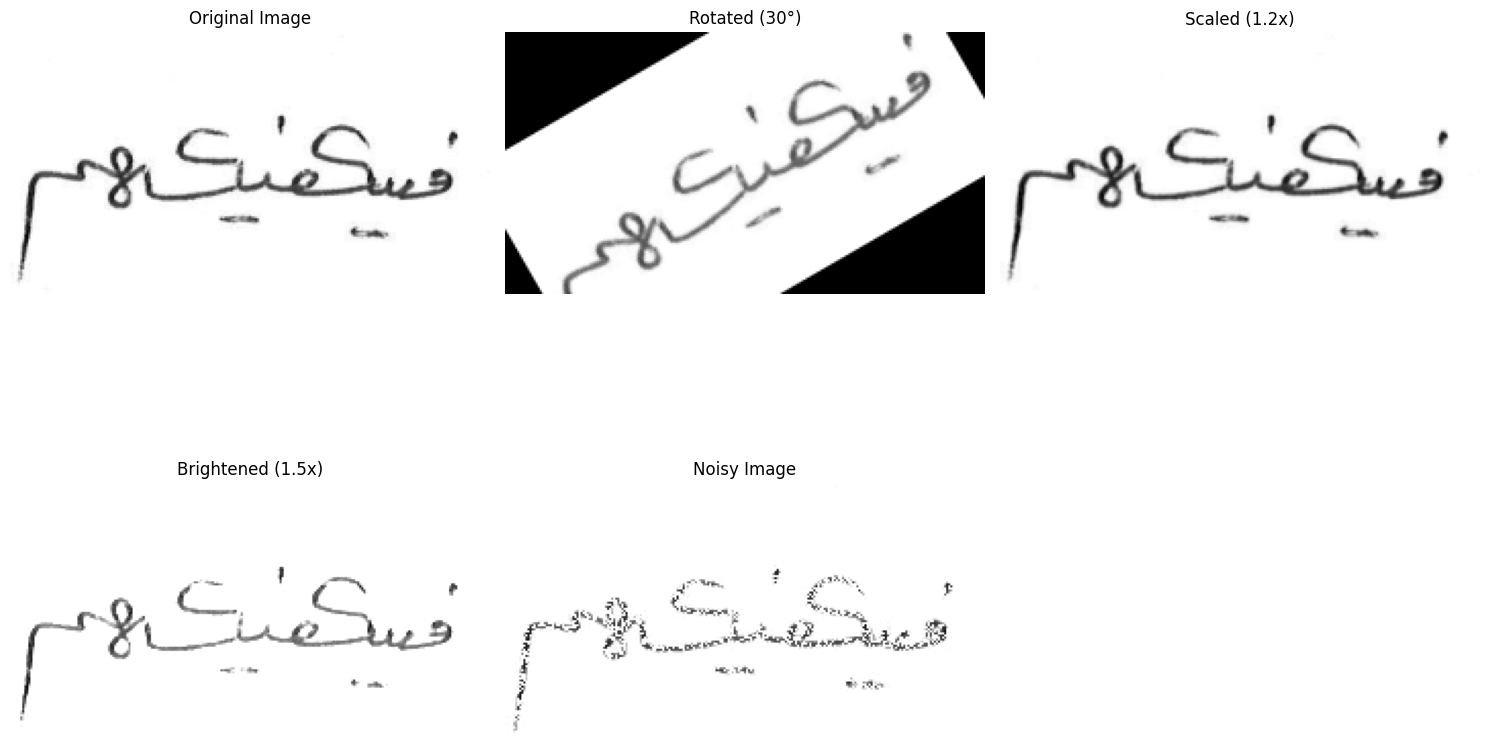

In [ ]:
# Load a sample image from the test set
sample_image_path = test_images[0]
sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)

if sample_image is None:
    raise ValueError(f"Failed to load image: {sample_image_path}")

rotated_image = rotate_image(sample_image, angle=30)
scaled_image = scale_image(sample_image, scale_factor=1.2)
brightened_image = adjust_illumination(sample_image, brightness_factor=1.5)
noisy_image = add_noise(sample_image)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(rotated_image, cmap='gray')
plt.title("Rotated (30°)")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(scaled_image, cmap='gray')
plt.title("Scaled (1.2x)")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(brightened_image, cmap='gray')
plt.title("Brightened (1.5x)")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(noisy_image, cmap='gray')
plt.title("Noisy Image")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Function to preprocess images (load as grayscale, binary, and sharpened)
def preprocess_images(image_paths):
    images = []

    sharpening_kernel = np.array([[0, -1, 0],
                                   [-1, 5, -1],
                                   [0, -1, 0]])

    for img_path in image_paths:
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Warning: Failed to load image {img_path}")
            continue

        # Convert the image to binary
        _, image = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)

        # Sharpen the image
        image = cv2.filter2D(image, -1, sharpening_kernel)

        # Ensure 8-bit format
        image = np.uint8(image)

        images.append(image)
    return images

# Preprocess the training and testing images
train_images_preprocessed = preprocess_images(train_images)
test_images_preprocessed = preprocess_images(test_images)

print(f"Number of preprocessed training images: {len(train_images_preprocessed)}")
print(f"Number of preprocessed testing images: {len(test_images_preprocessed)}")


Number of preprocessed training images: 6515
Number of preprocessed testing images: 1629


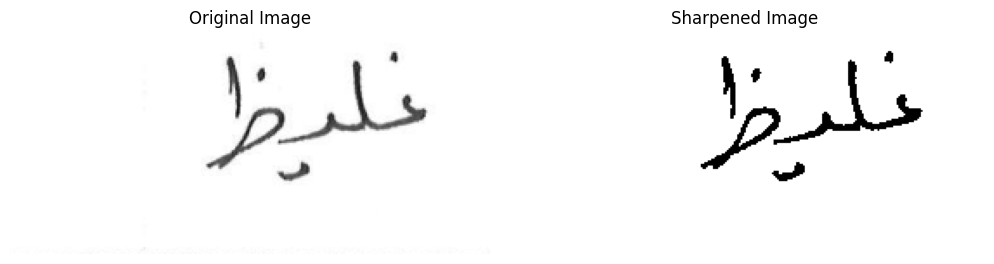

In [ ]:
import matplotlib.pyplot as plt

sample_image_path = train_images[0]
original_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)

# Apply sharpening
_, binary_image = cv2.threshold(original_image, 200, 255, cv2.THRESH_BINARY)
sharpening_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharpened_image = cv2.filter2D(binary_image, -1, sharpening_kernel)

# Plot the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sharpened_image, cmap='gray')
plt.title("Sharpened Image")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np

# Function to extract SIFT features
def extract_features(images, max_keypoints=1000):
    detector = cv2.SIFT_create(nfeatures=max_keypoints)
    keypoints_list = []
    descriptors_list = []

    for idx, image in enumerate(images):
        keypoints, descriptors = detector.detectAndCompute(image, None)

        if descriptors is None:
            descriptors = np.array([])

        keypoints_list.append(keypoints)
        descriptors_list.append(descriptors)

        print(f"Image {idx+1}: {len(keypoints)} keypoints")

    return keypoints_list, descriptors_list


# Extract SIFT features for training and testing images
train_keypoints, train_descriptors = extract_features(train_images_preprocessed)
test_keypoints, test_descriptors = extract_features(test_images_preprocessed)

print(f"Number of training images processed: {len(train_keypoints)}")
print(f"Keypoints in first training image: {len(train_keypoints[0])}")
print(f"Descriptors shape in first training image: {train_descriptors[0].shape}")

print(f"Number of testing images processed: {len(test_keypoints)}")
print(f"Keypoints in first testing image: {len(test_keypoints[0])}")
print(f"Descriptors shape in first testing image: {test_descriptors[0].shape}")


Streaming output truncated to the last 5000 lines.
Image 3151: 43 keypoints
Image 3152: 14 keypoints
Image 3153: 31 keypoints
Image 3154: 74 keypoints
Image 3155: 126 keypoints
Image 3156: 28 keypoints
Image 3157: 54 keypoints
Image 3158: 124 keypoints
Image 3159: 70 keypoints
Image 3160: 188 keypoints
Image 3161: 53 keypoints
Image 3162: 87 keypoints
Image 3163: 97 keypoints
Image 3164: 52 keypoints
Image 3165: 69 keypoints
Image 3166: 80 keypoints
Image 3167: 87 keypoints
Image 3168: 100 keypoints
Image 3169: 25 keypoints
Image 3170: 100 keypoints
Image 3171: 42 keypoints
Image 3172: 131 keypoints
Image 3173: 64 keypoints
Image 3174: 112 keypoints
Image 3175: 63 keypoints
Image 3176: 67 keypoints
Image 3177: 88 keypoints
Image 3178: 93 keypoints
Image 3179: 75 keypoints
Image 3180: 142 keypoints
Image 3181: 114 keypoints
Image 3182: 66 keypoints
Image 3183: 25 keypoints
Image 3184: 50 keypoints
Image 3185: 79 keypoints
Image 3186: 98 keypoints
Image 3187: 50 keypoints
Image 3188: 31 

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Combine all descriptors into a single list
def combine_descriptors(descriptors_list):
    combined_descriptors = []
    for descriptors in descriptors_list:
        if descriptors is not None and len(descriptors) > 0:
            combined_descriptors.extend(descriptors)
    return np.array(combined_descriptors)

all_descriptors = combine_descriptors(train_descriptors)

print(f"Total number of descriptors: {all_descriptors.shape}")

# Use KMeans to create a visual vocabulary
num_clusters = 1000
print("Clustering descriptors with KMeans...")
kmeans = KMeans(n_clusters=num_clusters, random_state=42, max_iter=600)
kmeans.fit(all_descriptors)

print("Visual vocabulary created.")


Total number of descriptors: (495176, 128)
Clustering descriptors with KMeans...
Visual vocabulary created.


In [ ]:
# Function to create a histogram of visual words for each image
def create_histograms(descriptors_list, kmeans, num_clusters):
    histograms = []
    for descriptors in descriptors_list:
        if descriptors is not None and len(descriptors) > 0:
            cluster_indices = kmeans.predict(descriptors)
            histogram, _ = np.histogram(cluster_indices, bins=np.arange(num_clusters+1))
        else:
            histogram = np.zeros(num_clusters)
        histograms.append(histogram)
    return np.array(histograms)

# Create histograms for training and testing sets
X_train_hist = create_histograms(train_descriptors, kmeans, num_clusters)
X_test_hist = create_histograms(test_descriptors, kmeans, num_clusters)

print(f"Training histogram shape: {X_train_hist.shape}")
print(f"Testing histogram shape: {X_test_hist.shape}")


Training histogram shape: (6515, 1000)
Testing histogram shape: (1629, 1000)


In [ ]:
import numpy as np

train_sum = np.sum(X_train_hist, axis=1, keepdims=True)
test_sum = np.sum(X_test_hist, axis=1, keepdims=True)

X_train_hist = np.divide(X_train_hist, train_sum, where=train_sum != 0)
X_test_hist = np.divide(X_test_hist, test_sum, where=test_sum != 0)

print("Histograms normalized.")

Histograms normalized.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Train the SVM classifier with RBF kernel
print("Training the SVM classifier with RBF kernel...")
svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=2, gamma=0.0005))
svm.fit(X_train_hist, train_labels)

# Predict on the test set
y_pred_svm = svm.predict(X_test_hist)

# Evaluate the model
print("\nSVM (RBF Kernel) Classification Report:")
print(classification_report(test_labels, y_pred_svm))

# Print overall accuracy
svm_accuracy = accuracy_score(test_labels, y_pred_svm)
print(f"SVM (RBF Kernel) Test Set Accuracy: {svm_accuracy * 100:.2f}%")


Training the SVM classifier with RBF kernel...

SVM (RBF Kernel) Classification Report:
              precision    recall  f1-score   support

     user001       0.69      0.60      0.64        30
     user002       0.32      0.53      0.40        17
     user003       0.18      0.19      0.18        16
     user004       0.17      0.31      0.22        16
     user005       0.22      0.26      0.24        19
     user006       0.43      0.40      0.41        15
     user007       0.17      0.38      0.24        13
     user008       0.70      0.61      0.65        23
     user009       0.35      0.36      0.36        22
     user010       0.23      0.35      0.28        23
     user011       0.94      0.50      0.65        30
     user012       0.44      0.33      0.38        21
     user013       0.67      0.29      0.40        21
     user014       0.38      0.45      0.42        22
     user015       0.33      0.21      0.26        24
     user016       0.58      0.68      0.62    

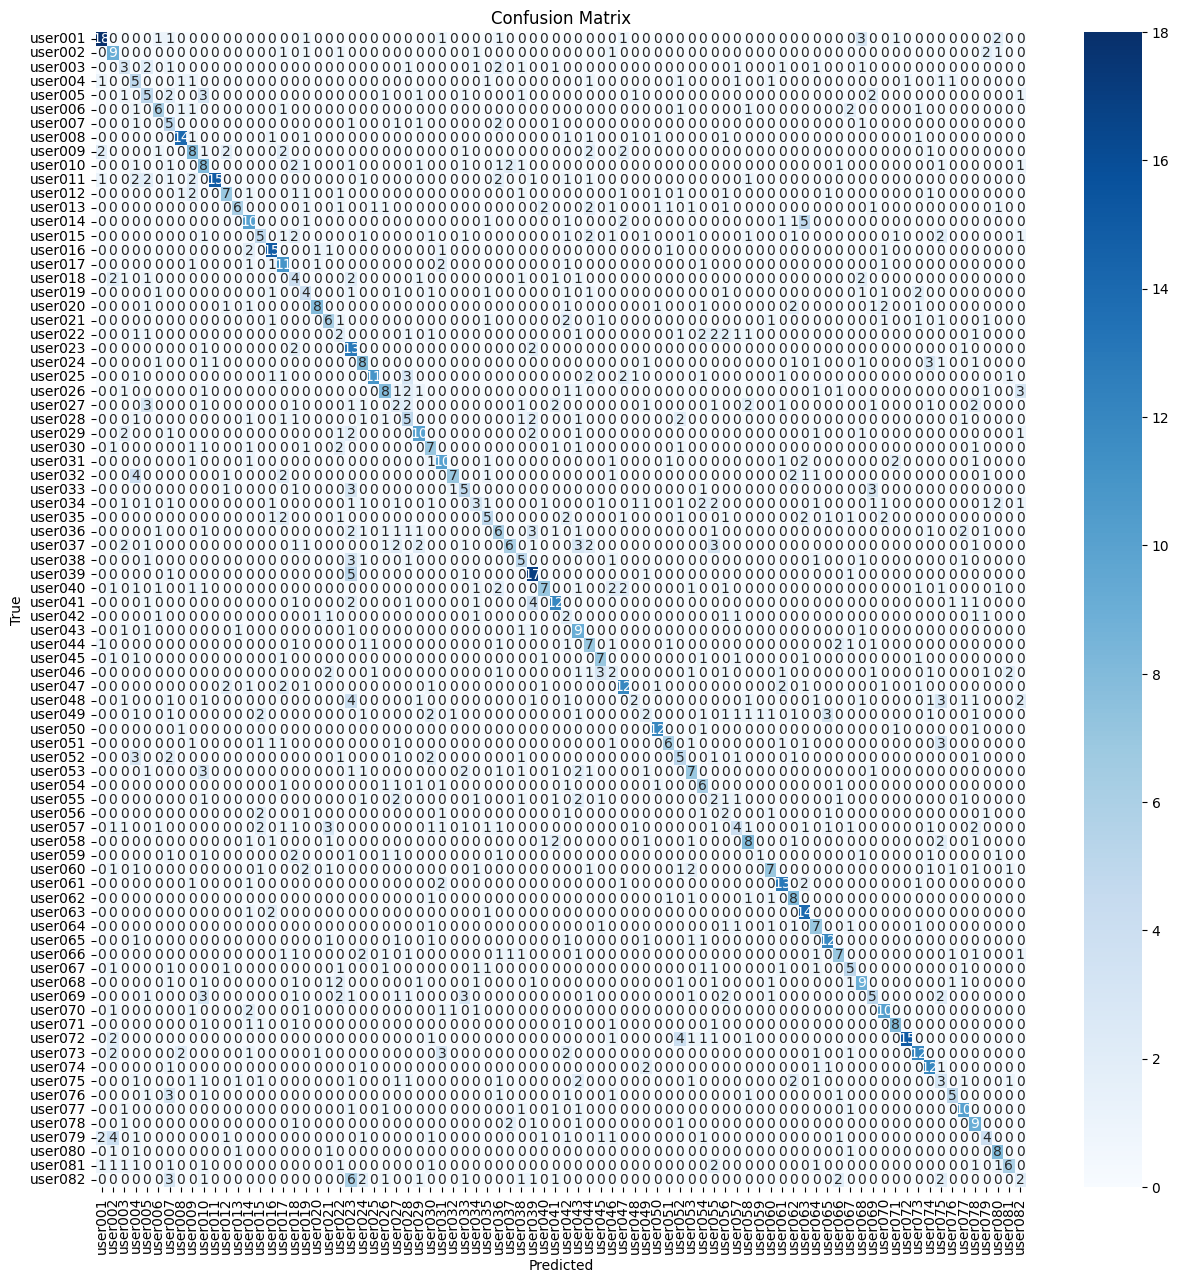

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

labels_ = list(set(test_labels))
labels_.sort()

plot_confusion_matrix(test_labels, y_pred_svm, labels=labels_)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

print("Training the Random Forest classifier...")
rf_model = RandomForestClassifier(n_estimators=800, random_state=42, n_jobs=-1)
rf_model.fit(X_train_hist, train_labels)

y_pred = rf_model.predict(X_test_hist)

print("\nClassification Report:")
print(classification_report(test_labels, y_pred))

accuracy = accuracy_score(test_labels, y_pred)
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")

Training the Random Forest classifier...

Classification Report:
              precision    recall  f1-score   support

     user001       0.67      0.20      0.31        30
     user002       0.32      0.71      0.44        17
     user003       0.14      0.19      0.16        16
     user004       0.26      0.31      0.29        16
     user005       0.19      0.21      0.20        19
     user006       0.24      0.33      0.28        15
     user007       0.12      0.15      0.13        13
     user008       0.37      0.70      0.48        23
     user009       0.31      0.41      0.35        22
     user010       0.28      0.30      0.29        23
     user011       0.50      0.27      0.35        30
     user012       0.20      0.19      0.20        21
     user013       0.20      0.24      0.22        21
     user014       0.21      0.23      0.22        22
     user015       0.00      0.00      0.00        24
     user016       0.43      0.73      0.54        22
     user017    

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Train the SVM classifier with RBF kernel
print("Training the SVM classifier with RBF kernel...")
svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=2, gamma=0.0005))
svm.fit(X_train_hist, train_labels)

# Predict on the test set
y_pred_svm = svm.predict(X_test_hist)

# Evaluate the model
print("\nSVM (RBF Kernel) Classification Report:")
print(classification_report(augmented_labels, y_pred_svm))

# Print overall accuracy
svm_accuracy = accuracy_score(augmented_labels, y_pred_svm)
print(f"SVM (RBF Kernel) Test Set Accuracy: {svm_accuracy * 100:.2f}%")


Training the SVM classifier with RBF kernel...

SVM (RBF Kernel) Classification Report:
              precision    recall  f1-score   support

     user001       0.17      0.13      0.15        30
     user002       0.29      0.12      0.17        17
     user003       0.02      0.06      0.03        16
     user004       0.00      0.00      0.00        16
     user005       0.00      0.00      0.00        19
     user006       0.05      0.07      0.06        15
     user007       0.05      0.08      0.06        13
     user008       0.06      0.09      0.07        23
     user009       0.11      0.27      0.16        22
     user010       0.00      0.00      0.00        23
     user011       0.00      0.00      0.00        30
     user012       0.00      0.00      0.00        21
     user013       0.00      0.00      0.00        21
     user014       0.08      0.18      0.11        22
     user015       0.00      0.00      0.00        24
     user016       0.09      0.23      0.12    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def match_keypoints_batch(images, keypoints, descriptors, pair_indices=None, max_keypoints=500, ratio_test=0.8):
    results = []

    if pair_indices is None:
        pair_indices = [(i, i + 1) for i in range(len(images) - 1)]

    for (i, j) in pair_indices:
        print(f"Matching Image {i} and Image {j}...")

        # Extract keypoints and descriptors for the pair
        image1, image2 = images[i], images[j]
        keypoints1, descriptors1 = keypoints[i], descriptors[i]
        keypoints2, descriptors2 = keypoints[j], descriptors[j]

        if descriptors1 is None or descriptors2 is None:
            print(f"Skipping pair ({i}, {j}) due to missing descriptors.")
            continue

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)

        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(descriptors1, descriptors2, k=2)

        good_matches = [m for m, n in matches if m.distance < ratio_test * n.distance]

        print(f"Good matches for pair ({i}, {j}): {len(good_matches)}")

        # Check for minimum matches before applying RANSAC
        if len(good_matches) >= 4:
            pts1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
            pts2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

            # Apply RANSAC
            H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

            if mask is not None:
                inlier_matches = [good_matches[k] for k in range(len(mask)) if mask.ravel()[k]]
                print(f"Inlier matches for pair ({i}, {j}): {len(inlier_matches)}")
            else:
                inlier_matches = []
                print(f"RANSAC failed for pair ({i}, {j}).")
        else:
            inlier_matches = good_matches
            print(f"RANSAC not applied for pair ({i}, {j}) due to insufficient matches.")

        similarity_score = len(inlier_matches) / max(1, len(good_matches))
        print(f"Similarity score for pair ({i}, {j}): {similarity_score:.2f}")

        # Draw matches
        matched_image = cv2.drawMatches(
            image1, keypoints1,
            image2, keypoints2,
            inlier_matches, None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )

        # Save results
        results.append({
            "pair": (i, j),
            "matched_image": matched_image,
            "inlier_matches": inlier_matches,
            "similarity_score": similarity_score,
        })

    return results


In [ ]:
# Match the first 5 images consecutively
pair_indices = [(0, 1), (1, 2), (2, 3), (3, 4)]


In [ ]:
from itertools import combinations
pair_indices = list(combinations(range(5), 2))


In [ ]:
results = match_keypoints_batch(
    images=train_images_preprocessed,
    keypoints=train_keypoints,
    descriptors=train_descriptors,
    pair_indices=pair_indices,
    max_keypoints=500,
    ratio_test=0.8
)


Matching Image 0 and Image 1...
Good matches for pair (0, 1): 15
Inlier matches for pair (0, 1): 7
Similarity score for pair (0, 1): 0.47
Matching Image 0 and Image 2...
Good matches for pair (0, 2): 10
Inlier matches for pair (0, 2): 6
Similarity score for pair (0, 2): 0.60
Matching Image 0 and Image 3...
Good matches for pair (0, 3): 8
Inlier matches for pair (0, 3): 4
Similarity score for pair (0, 3): 0.50
Matching Image 0 and Image 4...
Good matches for pair (0, 4): 7
Inlier matches for pair (0, 4): 5
Similarity score for pair (0, 4): 0.71
Matching Image 1 and Image 2...
Good matches for pair (1, 2): 10
Inlier matches for pair (1, 2): 7
Similarity score for pair (1, 2): 0.70
Matching Image 1 and Image 3...
Good matches for pair (1, 3): 5
Inlier matches for pair (1, 3): 0
Similarity score for pair (1, 3): 0.00
Matching Image 1 and Image 4...
Good matches for pair (1, 4): 9
Inlier matches for pair (1, 4): 6
Similarity score for pair (1, 4): 0.67
Matching Image 2 and Image 3...
Good m

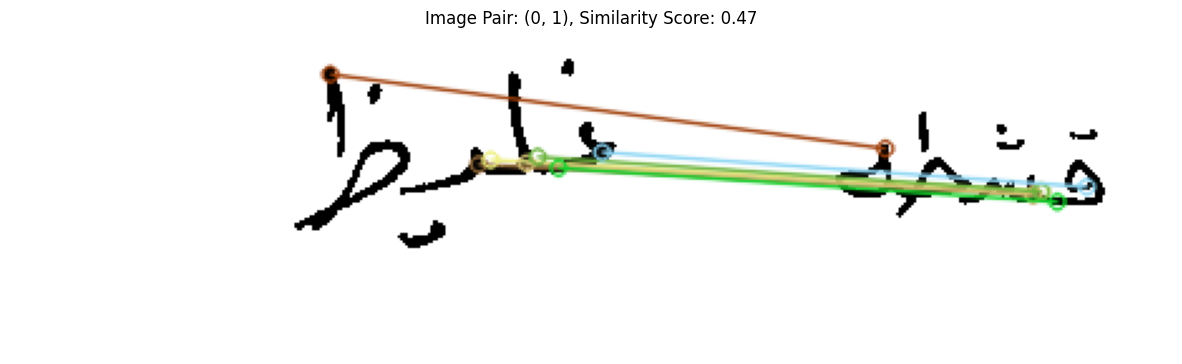

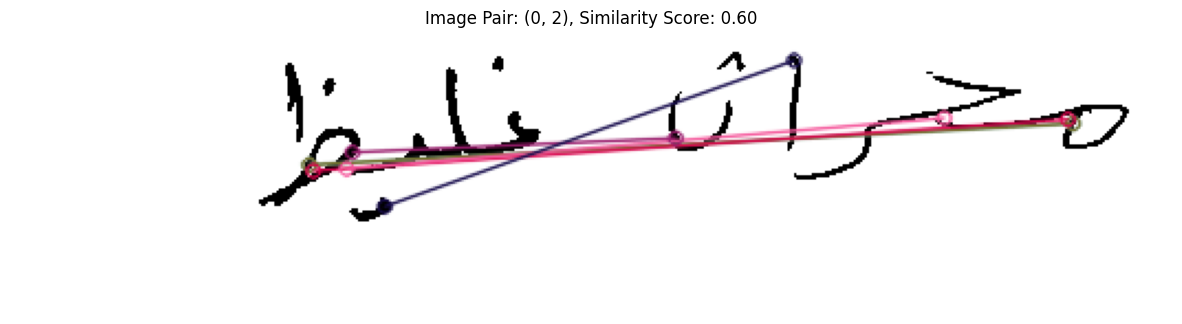

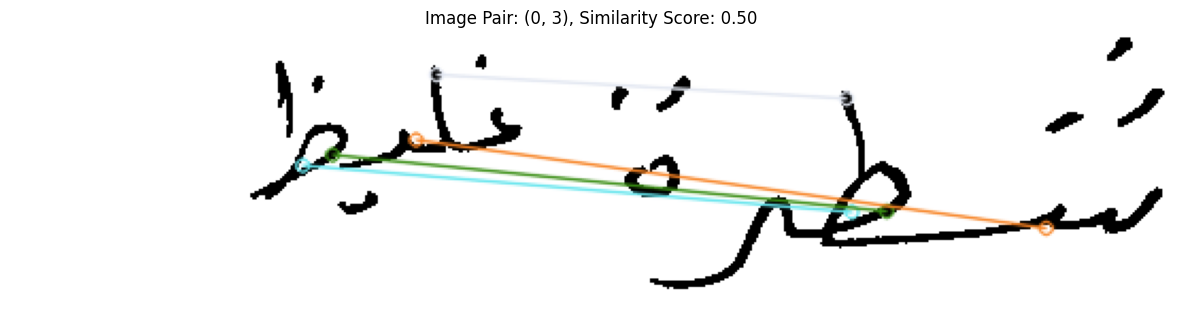

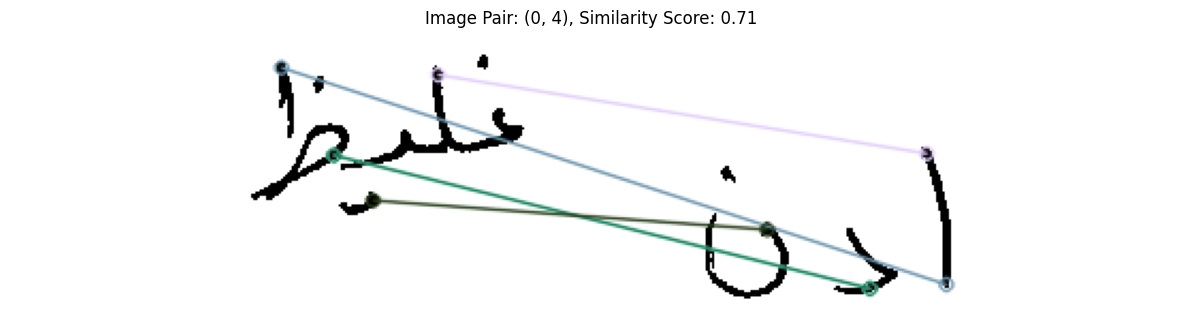

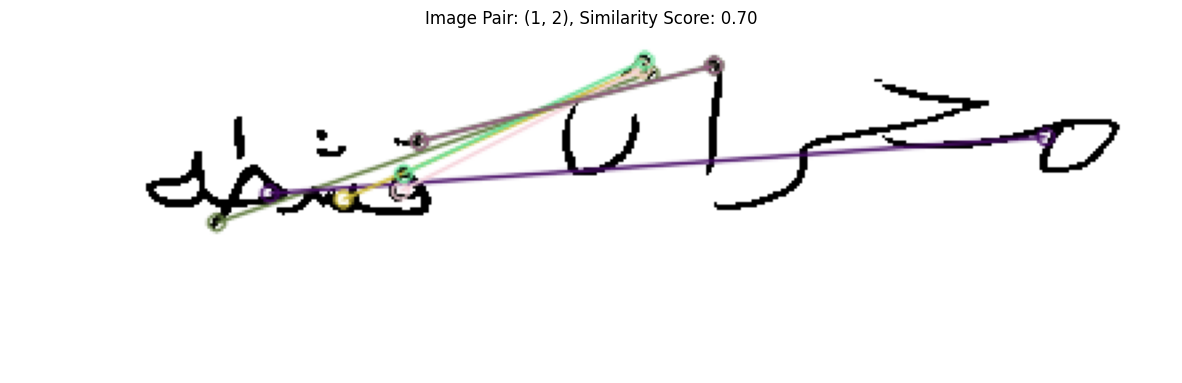

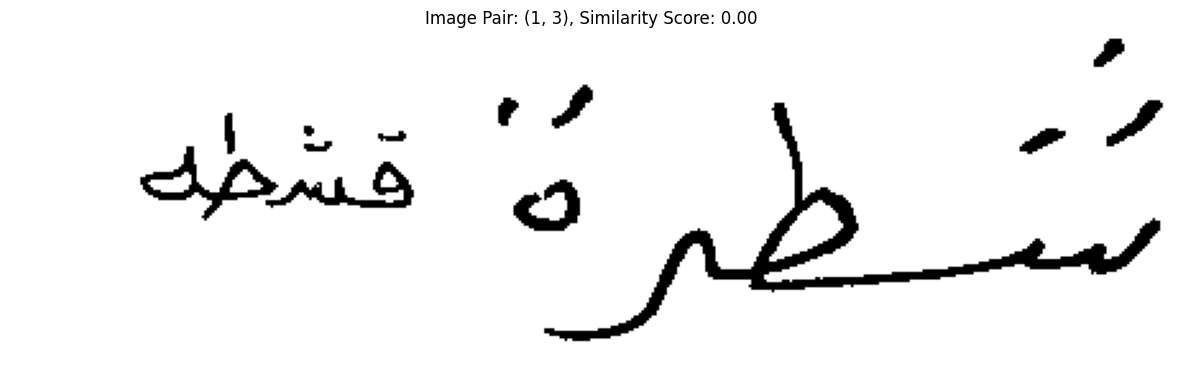

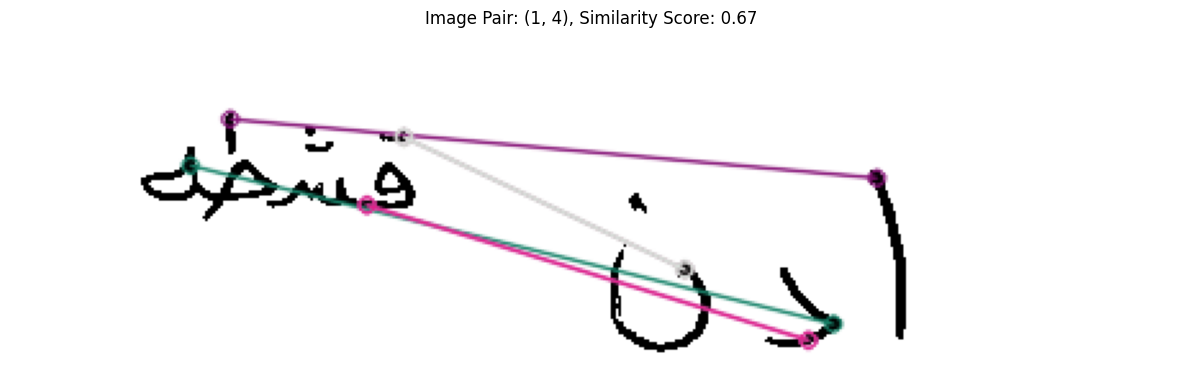

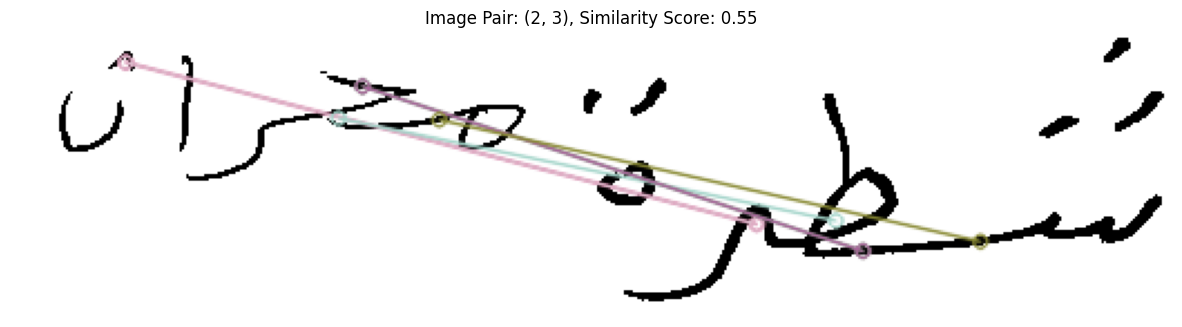

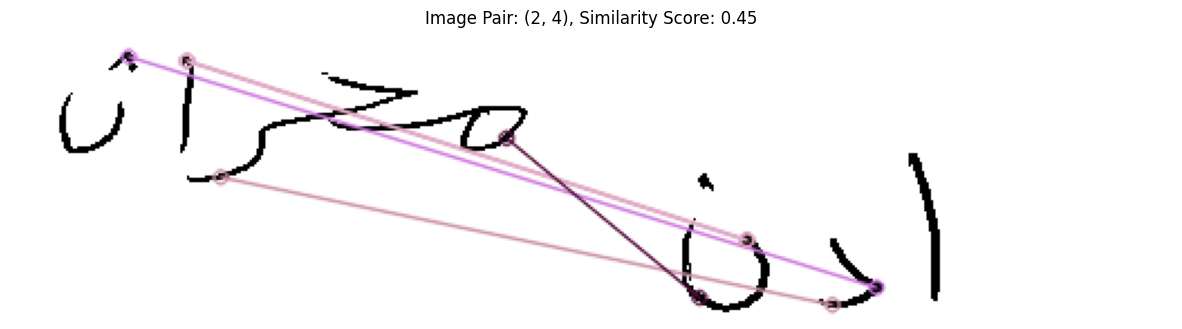

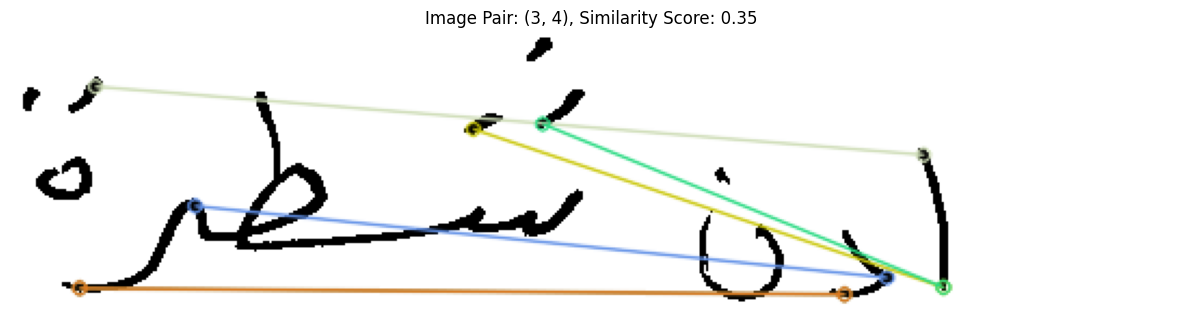

In [ ]:
for result in results:
    pair = result["pair"]
    matched_image = result["matched_image"]
    similarity_score = result["similarity_score"]

    # Display the matched image
    plt.figure(figsize=(15, 10))
    plt.imshow(matched_image)
    plt.title(f"Image Pair: {pair}, Similarity Score: {similarity_score:.2f}")
    plt.axis('off')
    plt.show()


In [ ]:
# Extract ORB features
def extract_orb_features(images, max_keypoints=1000):
    detector = cv2.ORB_create(nfeatures=max_keypoints)
    keypoints_list = []
    descriptors_list = []

    for idx, image in enumerate(images):
        keypoints, descriptors = detector.detectAndCompute(image, None)

        if descriptors is None:
            descriptors = np.array([])

        keypoints_list.append(keypoints)
        descriptors_list.append(descriptors)

        print(f"Image {idx+1}: {len(keypoints)} keypoints")

    return keypoints_list, descriptors_list

# Extract ORB features for training and testing images
train_keypoints, train_descriptors = extract_orb_features(train_images_preprocessed)
test_keypoints, test_descriptors = extract_orb_features(test_images_preprocessed)

print(f"Number of training images processed: {len(train_keypoints)}")
print(f"Number of testing images processed: {len(test_keypoints)}")


Streaming output truncated to the last 5000 lines.
Image 3147: 163 keypoints
Image 3148: 134 keypoints
Image 3149: 73 keypoints
Image 3150: 171 keypoints
Image 3151: 116 keypoints
Image 3152: 68 keypoints
Image 3153: 27 keypoints
Image 3154: 82 keypoints
Image 3155: 211 keypoints
Image 3156: 22 keypoints
Image 3157: 130 keypoints
Image 3158: 178 keypoints
Image 3159: 91 keypoints
Image 3160: 212 keypoints
Image 3161: 77 keypoints
Image 3162: 185 keypoints
Image 3163: 190 keypoints
Image 3164: 151 keypoints
Image 3165: 135 keypoints
Image 3166: 20 keypoints
Image 3167: 145 keypoints
Image 3168: 120 keypoints
Image 3169: 89 keypoints
Image 3170: 159 keypoints
Image 3171: 61 keypoints
Image 3172: 227 keypoints
Image 3173: 109 keypoints
Image 3174: 301 keypoints
Image 3175: 169 keypoints
Image 3176: 124 keypoints
Image 3177: 286 keypoints
Image 3178: 160 keypoints
Image 3179: 183 keypoints
Image 3180: 166 keypoints
Image 3181: 220 keypoints
Image 3182: 198 keypoints
Image 3183: 104 keypoin

In [ ]:
from sklearn.cluster import KMeans

# Combine descriptors into a single array
def combine_descriptors(descriptors_list):
    combined_descriptors = []
    for descriptors in descriptors_list:
        if len(descriptors) > 0:
            combined_descriptors.extend(descriptors)
    return np.array(combined_descriptors)

# Combine training descriptors
all_descriptors = combine_descriptors(train_descriptors)
print(f"Total number of descriptors: {all_descriptors.shape}")

# Perform KMeans clustering
num_clusters = 500
kmeans = KMeans(n_clusters=num_clusters, random_state=42, max_iter=600)
kmeans.fit(all_descriptors)

print("KMeans clustering completed.")


Total number of descriptors: (853206, 32)
KMeans clustering completed.


In [ ]:
# Create histograms for visual words
def create_histograms(descriptors_list, kmeans, num_clusters):
    histograms = []
    for descriptors in descriptors_list:
        if len(descriptors) > 0:
            cluster_indices = kmeans.predict(descriptors)
            histogram, _ = np.histogram(cluster_indices, bins=np.arange(num_clusters + 1))
        else:
            histogram = np.zeros(num_clusters)
        histograms.append(histogram)
    return np.array(histograms)

# Create histograms for training and testing sets
X_train_hist = create_histograms(train_descriptors, kmeans, num_clusters)
X_test_hist = create_histograms(test_descriptors, kmeans, num_clusters)

print(f"Training histogram shape: {X_train_hist.shape}")
print(f"Testing histogram shape: {X_test_hist.shape}")


Training histogram shape: (6515, 500)
Testing histogram shape: (1629, 500)


In [ ]:
# Normalize histograms
train_sum = np.sum(X_train_hist, axis=1, keepdims=True)
test_sum = np.sum(X_test_hist, axis=1, keepdims=True)

X_train_hist = np.divide(X_train_hist, train_sum, where=train_sum != 0)
X_test_hist = np.divide(X_test_hist, test_sum, where=test_sum != 0)

print("Histograms normalized.")


Histograms normalized.


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train SVM with RBF kernel
svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.7, gamma=0.0005))
svm.fit(X_train_hist, train_labels)

# Predict on the test set
y_pred_svm = svm.predict(X_test_hist)

# Evaluate performance
print("\nSVM (RBF Kernel) Classification Report:")
print(classification_report(test_labels, y_pred_svm))

# Print overall accuracy
svm_accuracy = accuracy_score(test_labels, y_pred_svm)
print(f"SVM (RBF Kernel) Test Set Accuracy: {svm_accuracy * 100:.2f}%")



SVM (RBF Kernel) Classification Report:
              precision    recall  f1-score   support

     user001       0.36      0.13      0.20        30
     user002       0.24      0.29      0.26        17
     user003       0.13      0.19      0.15        16
     user004       0.17      0.31      0.22        16
     user005       0.10      0.16      0.12        19
     user006       0.08      0.07      0.07        15
     user007       0.12      0.31      0.18        13
     user008       0.41      0.30      0.35        23
     user009       0.26      0.50      0.34        22
     user010       0.18      0.09      0.12        23
     user011       0.67      0.07      0.12        30
     user012       0.00      0.00      0.00        21
     user013       0.00      0.00      0.00        21
     user014       0.28      0.23      0.25        22
     user015       0.00      0.00      0.00        24
     user016       0.14      0.05      0.07        22
     user017       0.57      0.20      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


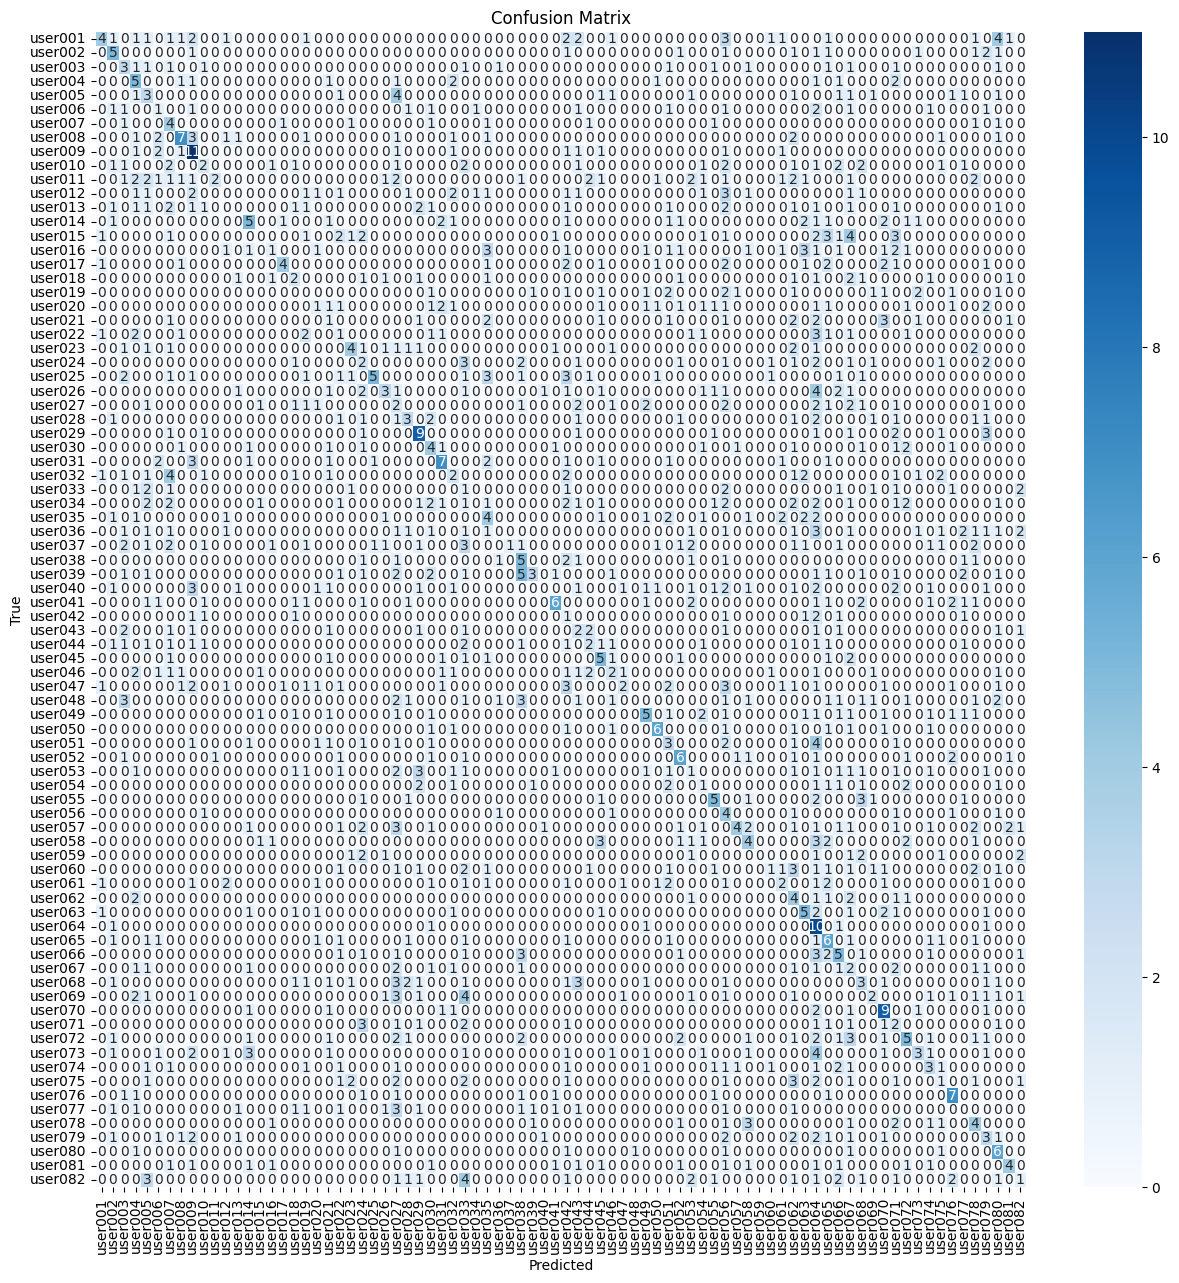

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

labels_ = list(set(test_labels))
labels_.sort()

# Call the function with correct label names
plot_confusion_matrix(test_labels, y_pred_svm, labels=labels_)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train the Random Forest classifier
print("Training the Random Forest classifier...")
rf_model = RandomForestClassifier(n_estimators=800, random_state=42, n_jobs=-1)
rf_model.fit(X_train_hist, train_labels)

# Predict on the test set
y_pred = rf_model.predict(X_test_hist)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(test_labels, y_pred))

# Print overall accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")

Training the Random Forest classifier...

Classification Report:
              precision    recall  f1-score   support

     user001       0.26      0.17      0.20        30
     user002       0.07      0.24      0.10        17
     user003       0.09      0.25      0.14        16
     user004       0.12      0.19      0.15        16
     user005       0.10      0.05      0.07        19
     user006       0.17      0.13      0.15        15
     user007       0.18      0.62      0.28        13
     user008       0.30      0.52      0.38        23
     user009       0.22      0.45      0.30        22
     user010       0.16      0.13      0.14        23
     user011       0.33      0.07      0.11        30
     user012       0.06      0.05      0.05        21
     user013       0.14      0.05      0.07        21
     user014       0.12      0.05      0.07        22
     user015       0.07      0.04      0.05        24
     user016       0.62      0.23      0.33        22
     user017    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Train the SVM classifier with RBF kernel
print("Training the SVM classifier with RBF kernel...")
svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=2, gamma=0.0005))
svm.fit(X_train_hist, train_labels)

# Predict on the test set
y_pred_svm = svm.predict(X_test_hist)

# Evaluate the model
print("\nSVM (RBF Kernel) Classification Report:")
print(classification_report(augmented_labels, y_pred_svm))

# Print overall accuracy
svm_accuracy = accuracy_score(augmented_labels, y_pred_svm)
print(f"SVM (RBF Kernel) Test Set Accuracy: {svm_accuracy * 100:.2f}%")


In [ ]:
def match_keypoints_batch_orb(images, keypoints, descriptors, pair_indices=None, max_keypoints=500, ratio_test=0.8):
    results = []

    if pair_indices is None:
        pair_indices = [(i, i + 1) for i in range(len(images) - 1)]

    for (i, j) in pair_indices:
        print(f"Matching Image {i} and Image {j}...")

        image1, image2 = images[i], images[j]
        keypoints1, descriptors1 = keypoints[i], descriptors[i]
        keypoints2, descriptors2 = keypoints[j], descriptors[j]

        if descriptors1 is None or descriptors2 is None:
            print(f"Skipping pair ({i}, {j}) due to missing descriptors.")
            continue

        descriptors1 = np.float32(descriptors1)
        descriptors2 = np.float32(descriptors2)

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)

        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(descriptors1, descriptors2, k=2)

        good_matches = [m for m, n in matches if m.distance < ratio_test * n.distance]

        print(f"Good matches for pair ({i}, {j}): {len(good_matches)}")

        # Check for minimum matches before applying RANSAC
        if len(good_matches) >= 4:
            pts1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
            pts2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

            # Apply RANSAC
            H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

            if mask is not None:
                inlier_matches = [good_matches[k] for k in range(len(mask)) if mask.ravel()[k]]
                print(f"Inlier matches for pair ({i}, {j}): {len(inlier_matches)}")
            else:
                inlier_matches = []
                print(f"RANSAC failed for pair ({i}, {j}).")
        else:
            inlier_matches = good_matches
            print(f"RANSAC not applied for pair ({i}, {j}) due to insufficient matches.")

        # Compute similarity score
        similarity_score = len(inlier_matches) / max(1, len(good_matches))
        print(f"Similarity score for pair ({i}, {j}): {similarity_score:.2f}")

        # Draw matches
        matched_image = cv2.drawMatches(
            image1, keypoints1,
            image2, keypoints2,
            inlier_matches, None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )

        # Save results
        results.append({
            "pair": (i, j),
            "matched_image": matched_image,
            "inlier_matches": inlier_matches,
            "similarity_score": similarity_score,
        })

    return results


In [ ]:
pair_indices = list(combinations(range(5), 2))  # All pairs from the first 5 images


In [ ]:
results = match_keypoints_batch_orb(
    images=train_images_preprocessed,
    keypoints=keypoints,
    descriptors=descriptors,
    pair_indices=pair_indices,
    max_keypoints=500,
    ratio_test=0.8
)


Matching Image 0 and Image 1...
Good matches for pair (0, 1): 7
Inlier matches for pair (0, 1): 4
Similarity score for pair (0, 1): 0.57
Matching Image 0 and Image 2...
Good matches for pair (0, 2): 8
Inlier matches for pair (0, 2): 4
Similarity score for pair (0, 2): 0.50
Matching Image 0 and Image 3...
Good matches for pair (0, 3): 5
Inlier matches for pair (0, 3): 0
Similarity score for pair (0, 3): 0.00
Matching Image 0 and Image 4...
Good matches for pair (0, 4): 5
Inlier matches for pair (0, 4): 0
Similarity score for pair (0, 4): 0.00
Matching Image 1 and Image 2...
Good matches for pair (1, 2): 3
RANSAC not applied for pair (1, 2) due to insufficient matches.
Similarity score for pair (1, 2): 1.00
Matching Image 1 and Image 3...
Good matches for pair (1, 3): 7
Inlier matches for pair (1, 3): 5
Similarity score for pair (1, 3): 0.71
Matching Image 1 and Image 4...
Good matches for pair (1, 4): 5
Inlier matches for pair (1, 4): 0
Similarity score for pair (1, 4): 0.00
Matching Im

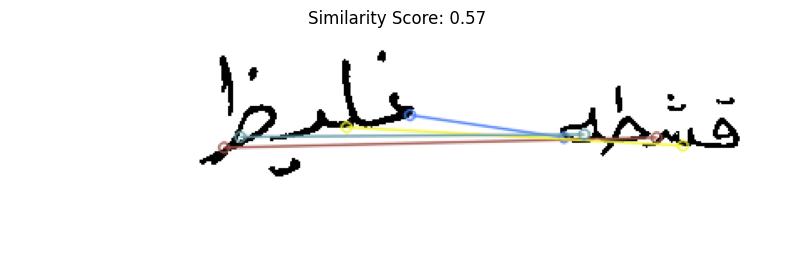

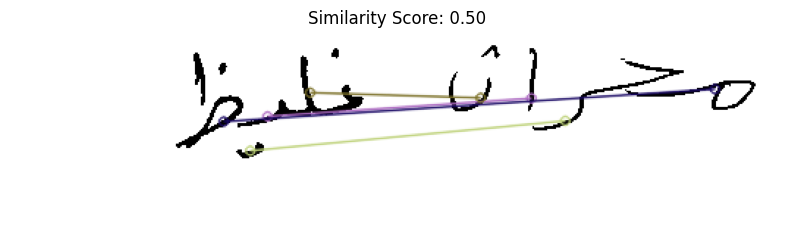

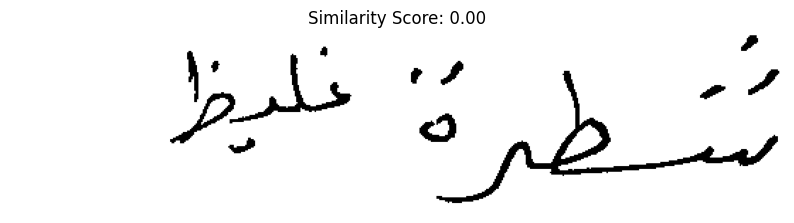

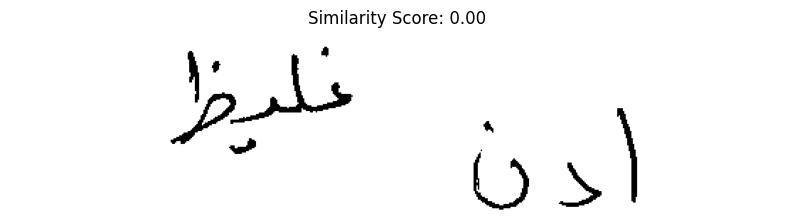

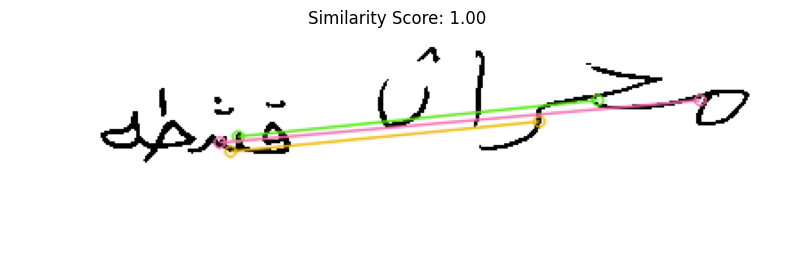

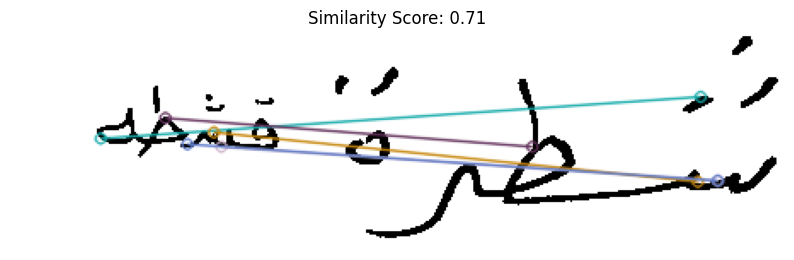

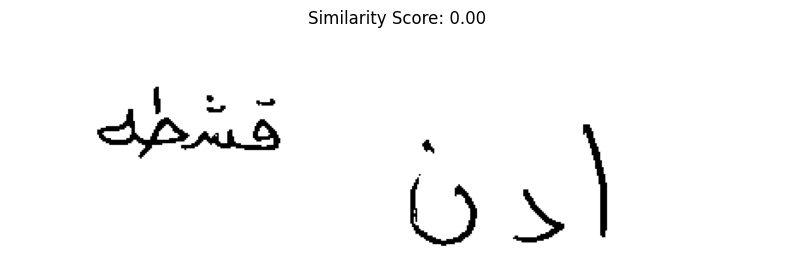

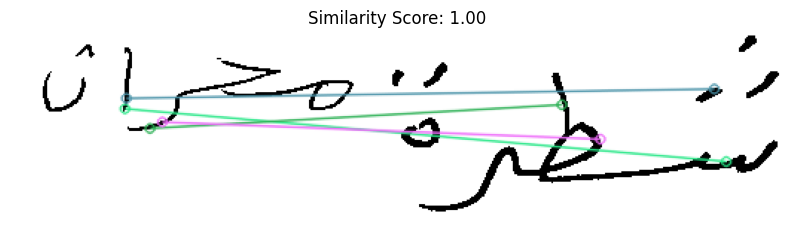

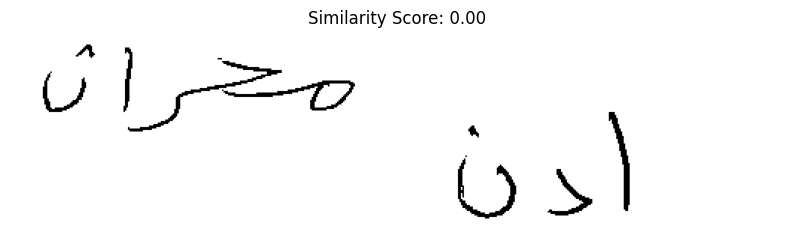

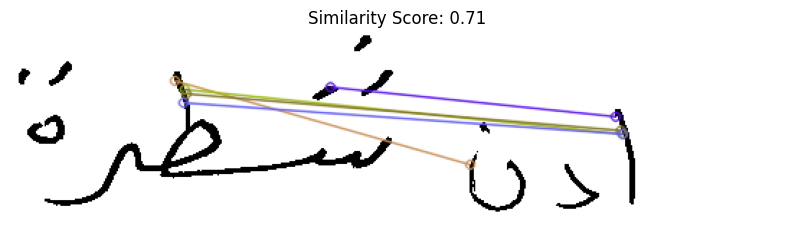

In [ ]:
import matplotlib.pyplot as plt

for result in results:
    matched_image = result["matched_image"]
    similarity_score = result["similarity_score"]

    # Create a plot for each matched image
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Similarity Score: {similarity_score:.2f}")
    plt.axis('off')
    plt.show()
